In [1]:
import os

import pathlib
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import imagesize
from tqdm import tqdm
import cv2

%matplotlib inline

In [2]:
data_path = 'C:/Users/akipp/Documents/GitHub/Data/Birds-400-Species-Image-Classification/'
# # provides the latin name for each class; unnecessary at this time
# birds_latin_names = pd.read_csv(data_path + 'birds_latin_names.csv')

# # provides information about image class sizes (half width and height) and whether they have been scaled or off set; unnecessary at this time
# class_dict = pd.read_csv(data_path + 'class_dict.csv')

# provides the subfolder file path for each image, the label, and which dataset it is part of: train, test, validation (valid); 
# both test and validation datasets contain 5 images per class
birds = pd.read_csv(data_path + 'birds.csv')
birds['full_filepaths'] = data_path + birds.filepaths

In [3]:
print(birds.shape)
birds.head()

(62388, 5)


,class index,filepaths,labels,data set,full_filepaths
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,C:/Users/akipp/Documents/GitHub/Data/Birds-400...
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,C:/Users/akipp/Documents/GitHub/Data/Birds-400...
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train,C:/Users/akipp/Documents/GitHub/Data/Birds-400...
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train,C:/Users/akipp/Documents/GitHub/Data/Birds-400...
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train,C:/Users/akipp/Documents/GitHub/Data/Birds-400...


In [4]:
# Check the number of images in each data set - train, test, validation sizes defined in dataset; 
# this could cause overfitting and may need to be changed
birds['data set'].value_counts()

train    58388
test      2000
valid     2000
Name: data set, dtype: int64

In [5]:
# Check for any missing values
birds.isna().sum()

class index       0
filepaths         0
labels            0
data set          0
full_filepaths    0
dtype: int64

In [6]:
# Check class counts in train and test datasets to know if any new classes will appear in test which the 
# model will not have seen; the number of classes is consistent
birds[birds['data set'] != 'valid'].groupby(['data set']).labels.nunique()

data set
test     400
train    400
Name: labels, dtype: int64

In [7]:
# Reduce the dataset to just the training data to prevent any data leakage; use test and validation datasets 
# as test data, and eventually break train data into train and validation data
birds = birds[birds['data set'] == 'train']

(array([126., 102.,  76.,  48.,  24.,  12.,   6.,   3.,   2.,   1.]),
 array([120. , 132.9, 145.8, 158.7, 171.6, 184.5, 197.4, 210.3, 223.2,
        236.1, 249. ]),
 <BarContainer object of 10 artists>)

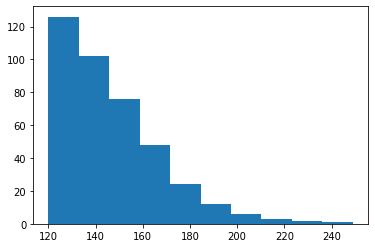

In [8]:
# Visualize the distribution of samples per class in the training dataset to determine if they are balanced; they are not
# Due to the wide range for the class imbalance, weighted classes or some kind of sampling or augmentation technique may be needed
# However, simpler methods, such as weighted classes or undersampling, may be sufficient and require no extra work
plt.hist(birds.labels.value_counts())

In [9]:
# Determine whether shapes of all the images are the same; they are, padding/resizing not needed for uniform model input shape, resizing optional for reducing training time
# using the imagesize package is much faster than using Image.open(x).size
tqdm.pandas()
image_sizes = birds[['full_filepaths']].progress_apply(lambda row: imagesize.get(row[0]), axis = 'columns', result_type = 'expand').rename({0: 'width', 1: 'height'}, axis = 'columns') 
birds = pd.concat([birds, image_sizes], axis = 'columns')
print('Width Min: {0}; Width Max: {1}'.format(birds.width.min(), birds.width.max()))
print('Height Min: {0}; Height Max: {1}'.format(birds.height.min(), birds.height.max()))

100%|██████████████████████████████████████████████████████████████████████████| 58388/58388 [00:07<00:00, 7899.67it/s]

Width Min: 224; Width Max: 224
Height Min: 224; Height Max: 224


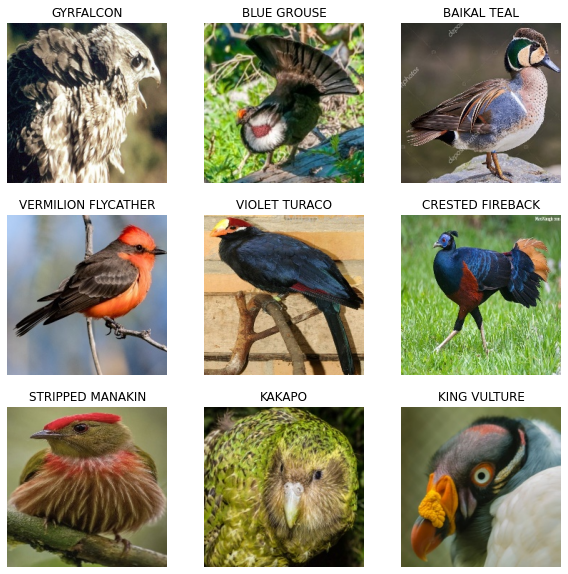

In [10]:
# Visualize several of the images from different classes - randomly select 9 images, each from a different class
bird_classes = birds.labels.unique()
random_bird_classes = bird_classes[np.random.randint(0, len(bird_classes), 9)]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(Image.open(np.random.choice(birds[birds.labels == random_bird_classes[i]].full_filepaths, 1)[0]))
    plt.title(random_bird_classes[i])
    plt.axis("off")

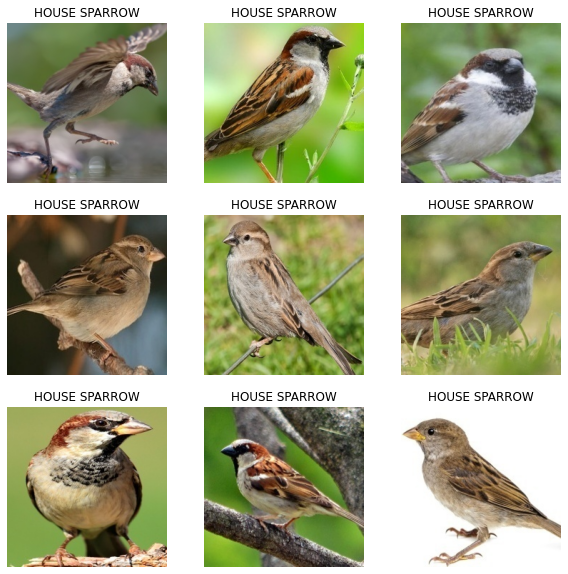

In [11]:
# Visualize several images from a single class to see the variety, in this case the variety of different angles for bird photos
random_bird_class = bird_classes[np.random.randint(0, len(bird_classes))]
random_birds_from_class = np.random.choice(birds[birds.labels == random_bird_class].full_filepaths, 9)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(Image.open(random_birds_from_class[i]))
    plt.title(random_bird_class)
    plt.axis("off")

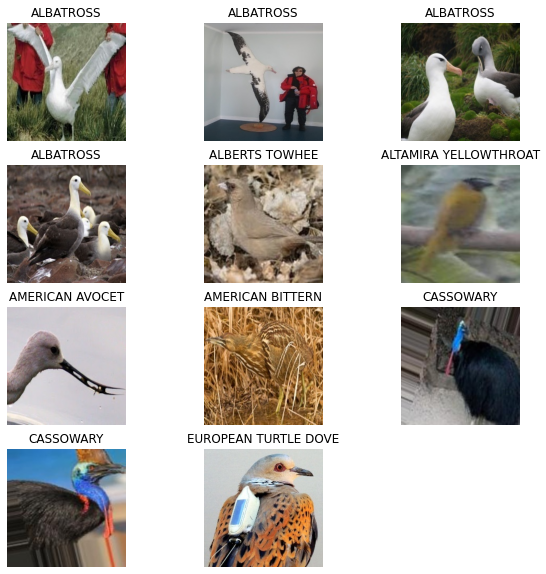

In [12]:
# Manually looking through some images to determine if there are any easily identifiable problems or outliers;
# There are some cases of image stretching, unusual items, multiple birds in a single image, people in the background, well camoflauged birds, and blurry images
# There are also some bird species/images which may be difficult to identify because the majority of images have vibrant colors, but others are dull/muted - AFRICAN EMERALD CUCKOO
# Has a backpack? train/EUROPEAN TURTLE DOVE/093.jpg
# Will need to determine if anything needs to be done about these...
odd_birds = ['train/CASSOWARY/122.jpg', 'train/CASSOWARY/139.jpg', 'train/EUROPEAN TURTLE DOVE/093.jpg', 
             'train/ALBATROSS/063.jpg', 'train/ALBATROSS/080.jpg', 'train/ALBATROSS/081.jpg', 'train/ALBATROSS/128.jpg', 
             'train/ALBERTS TOWHEE/093.jpg', 'train/ALTAMIRA YELLOWTHROAT/086.jpg', 'train/AMERICAN AVOCET/161.jpg', 'train/AMERICAN BITTERN/099.jpg']
odd_birds_subset = birds[birds.filepaths.isin(odd_birds)]
plt.figure(figsize=(10, 10))
for i in range(len(odd_birds)):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(Image.open(odd_birds_subset.full_filepaths.iloc[i]))
    plt.title(odd_birds_subset.labels.iloc[i])
    plt.axis("off")

In [13]:
# Check fraction of color vs greyscale images - there are a few
def is_grey_scale(image_value):
    w, h = image_value.size
    # shuffle the pixel index lists for generally quicker determination of color vs greyscale; gets around the issue of potential 
    # solid black or white borders around images - there are a few upon visual inspection. Could occasionally take longer if the 
    # sampling unluckily starts with black sections of an image
    w_list = np.arange(w)
    np.random.shuffle(w_list)
    h_list = np.arange(h)
    np.random.shuffle(h_list)
    for i in w_list:
        for j in h_list:
            r,g,b = image_value.getpixel((i,j))
            if r != g != b: return False
    return True

# Check color scale of training images
sample_fraction = 0.1
is_grey_list_train = []
for image_path in tqdm(birds[birds['data set'] == 'train']['full_filepaths'].sample(frac = sample_fraction)):
    image_value = Image.open(image_path).convert('RGB')
    is_grey_list_train.append(is_grey_scale(image_value))
    
print('Fraction of training data which is grey scale from sample:', np.sum(is_grey_list_train)/len(is_grey_list_train))
print('Count of training data which is grey scale from sample:', np.sum(is_grey_list_train))

100%|████████████████████████████████████████████████████████████████████████████| 5839/5839 [00:03<00:00, 1917.99it/s]

Fraction of training data which is grey scale from sample: 0.0
Count of training data which is grey scale from sample: 0


In [14]:
# Get mean intensity for each channel RGB
def get_rgb_mean(row):
    img = cv2.imread(row['full_filepaths'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # only necessary if we want output in RGB order, cv2 reads in images in BGR format
    return np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])

birds['R'], birds['G'], birds['B'] = zip(*birds.progress_apply(lambda row: get_rgb_mean(row), axis=1))

100%|██████████████████████████████████████████████████████████████████████████| 58388/58388 [00:49<00:00, 1183.89it/s]


In [15]:
def show_color_dist(df, num_imgs):
    fig, ax = plt.subplots(num_imgs, 2, figsize=(15,15))
    for idx, i in enumerate(np.random.choice(df['full_filepaths'], num_imgs)):
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[idx,0].imshow(img)
        ax[idx,0].axis('off')
        ax[idx,1].set_title('R={:.0f}, G={:.0f}, B={:.0f} '.format(np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2]))) 
        x, y = np.histogram(img[:,:,0], bins=255)
        ax[idx,1].bar(y[:-1], x, label='R', alpha=0.8, color='red')
        x, y = np.histogram(img[:,:,1], bins=255)
        ax[idx,1].bar(y[:-1], x, label='G', alpha=0.8, color='green')
        x, y = np.histogram(img[:,:,2], bins=255)
        ax[idx,1].bar(y[:-1], x, label='B', alpha=0.8, color='blue')
        ax[idx,1].legend()
        ax[idx,1].axis('off')

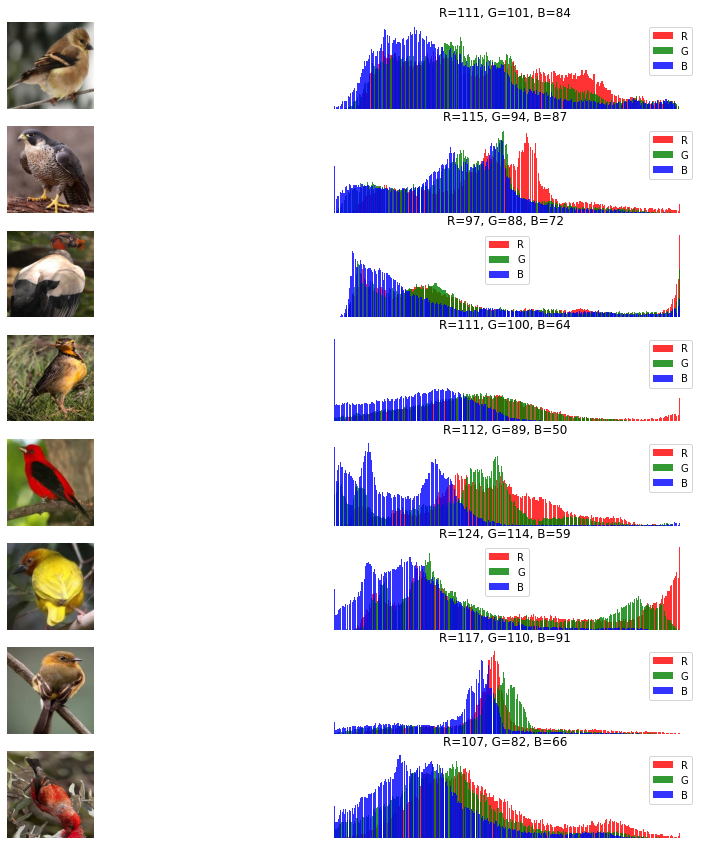

In [16]:
# Red images and their color distribution
df = birds[((birds['B']*1.05) < birds['R']) & ((birds['G']*1.05) < birds['R'])]
show_color_dist(df, 8)

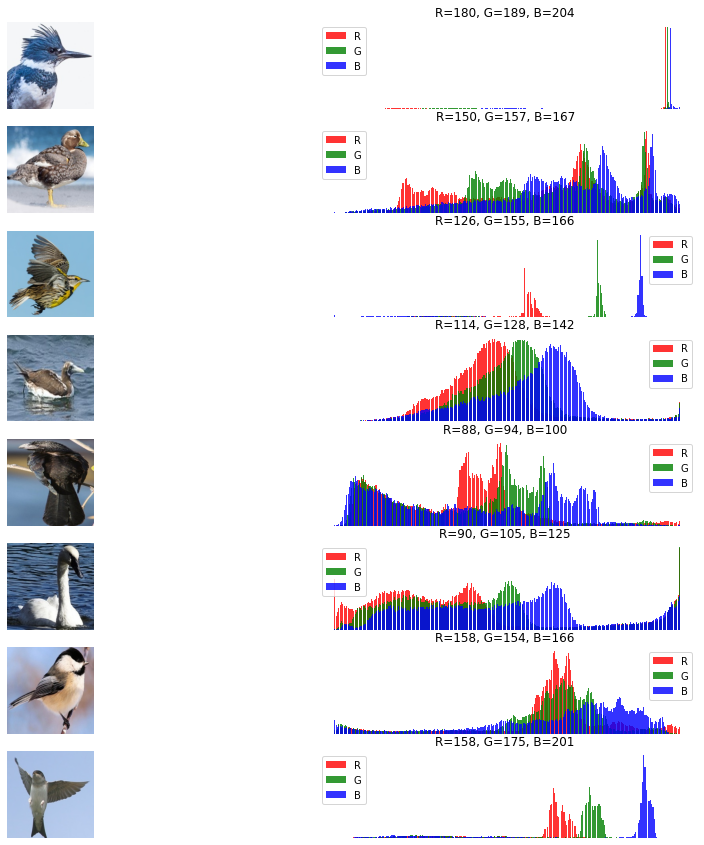

In [17]:
# Blue images and their color distribution
df = birds[(birds['B'] > 1.05*birds['R']) & (birds['B'] > 1.05*birds['G'])]
show_color_dist(df, 8)

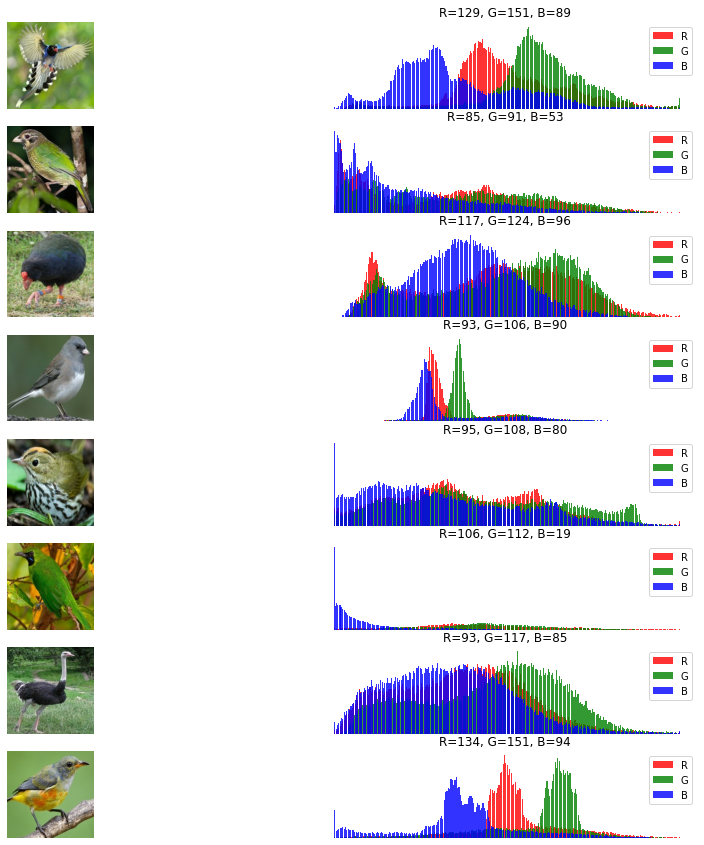

In [18]:
# Green images and their color distribution
df = birds[(birds['G'] > 1.05*birds['R']) & (birds['G'] > 1.05*birds['B'])]
show_color_dist(df, 8)